In [42]:
import matplotlib.pyplot as plt
import numpy as np
import time
from os import listdir, path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage
from sklearn.cluster import AgglomerativeClustering
import glob

In [43]:
def read_int(f):
    ba = bytearray(4)
    f.readinto(ba)
    prm = np.frombuffer(ba, dtype=np.int32)
    return prm[0]
    
def read_double(f):
    ba = bytearray(8)
    f.readinto(ba)
    prm = np.frombuffer(ba, dtype=np.double)
    return prm[0]

def read_double_tab(f, n):
    ba = bytearray(8*n)
    nr = f.readinto(ba)
    if nr != len(ba):
        return []
    else:
        prm = np.frombuffer(ba, dtype=np.double)
        return prm
    
def get_pics_from_file(filename):
    # Lecture du fichier d'infos + pics detectes (post-processing KeyFinder)
    f_pic = open(filename, "rb")
    info = dict()
    info["nb_pics"] = read_int(f_pic)
    info["freq_sampling_khz"] = read_double(f_pic)
    info["freq_trame_hz"] = read_double(f_pic)
    info["freq_pic_khz"] = read_double(f_pic)
    info["norm_fact"] = read_double(f_pic)
    tab_pics = []
    pics = read_double_tab(f_pic, info["nb_pics"])
    nb_trames = 1
    while len(pics) > 0:
        nb_trames = nb_trames+1
        tab_pics.append(pics)
        pics = read_double_tab(f_pic, info["nb_pics"])
    f_pic.close()
    arr = np.array(tab_pics)
    return arr, info

In [44]:
def get_pics(dir_pathname):
    # Compute filenames
    filenames = []
    for filename in listdir(dir_pathname):
        pathname = path.join(dir_pathname, filename)
        if path.isfile(pathname):
            filenames.append(filename)
    
    # Loop through filenames
    pics = []
    infos = []
    for filename in filenames:

        pathname = path.join(dir_pathname, filename)
        item, info = get_pics_from_file(pathname)
        
        infos.append(info)
        pics.append(item)
    
    return pics, infos

In [45]:
from PIL import Image
pics_nokey, _ = get_pics_from_file("./data/pics_NOKEY.bin")
pics_login, _ = get_pics_from_file("./data/pics_LOGINMDP.bin")
img = Image.new('L', (17, len(pics_login)))
pixels = []

for i, frame in enumerate(pics_login):
    noise_frame = pics_nokey[i]

    for i, p in enumerate(frame):
        result = p - noise_frame[i]

        if result < 0:
            result = 0

        pixels.append(int(result * 255))

img.putdata(pixels)
img.save("file.png")

# Moyenne

In [46]:
chunks = [
    (1481, 1836),
    (1837, 2140),
    (3011, 3222),
    (3223, 3323),
    (3324, 3677),
    (3679, 3781),
    (3786, 4032),
    (4033, 4141),
    (4143, 4421),
    (4423, 4563),
    (4565, 4821),
    (4824, 4970),
    (4973, 5067),
    (5909, 6058),
    (6272, 6419),
    (6617, 6735),
    (7024, 7155),
    (7425, 7539),
    (7813, 7931),
    (8178, 8297),
    (8552, 8670),
    (8897, 9028),
    (9188, 9336),
    (9539, 9670),
    (9839, 9982),
]

In [47]:
denoised = pics_login[:,:] - pics_nokey[:pics_login.shape[0],:]

In [48]:
test = ndimage.gaussian_filter1d(denoised,10,0)

In [49]:
ac = AgglomerativeClustering(compute_full_tree=True, distance_threshold=10, n_clusters=None)
yac = ac.fit_predict(test)
print(ac.n_clusters_)

16


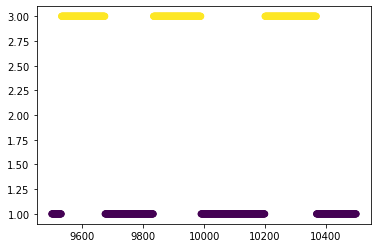

In [50]:
plt.figure()
l, h = 9500, 10500
plt.scatter(range(l,h), yac[l:h], c=yac[l:h])

plt.show()

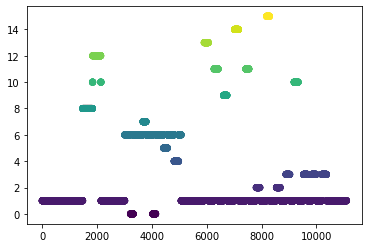

In [51]:
plt.figure()
l, h = 4000, 5000
plt.scatter(range(0,yac.size), yac[:], c=yac)

plt.show()

In [52]:
chunks_index = [0]
for i in range(yac.size - 1):
  if yac[i] != yac[i+1]:
    chunks_index.append(i)
chunks_index.append(yac.size)
chunks = [(x,y) for x,y in zip(chunks_index[:-1], chunks_index[1:])]

In [53]:
print(chunks)

[(0, 1477), (1477, 1833), (1833, 1843), (1843, 2135), (2135, 2146), (2146, 3010), (3010, 3219), (3219, 3322), (3322, 3675), (3675, 3788), (3788, 4032), (4032, 4139), (4139, 4426), (4426, 4568), (4568, 4811), (4811, 4974), (4974, 5067), (5067, 5910), (5910, 6059), (6059, 6269), (6269, 6418), (6418, 6614), (6614, 6737), (6737, 7014), (7014, 7161), (7161, 7425), (7425, 7538), (7538, 7807), (7807, 7937), (7937, 8186), (8186, 8289), (8289, 8542), (8542, 8679), (8679, 8890), (8890, 9028), (9028, 9187), (9187, 9335), (9335, 9531), (9531, 9674), (9674, 9833), (9833, 9989), (9989, 10199), (10199, 10368), (10368, 11101)]


In [55]:
class Key:
    def __init__(self, name, mean):
        self.name = name
        self.mean = mean

    def __str__(self):
        return f"Key(name='{self.name}', mean={self.mean})"

    def __repr__(self):
        return self.__str__()


login, _ = get_pics_from_file("./data/pics_LOGINMDP.bin")
noise, _ = get_pics_from_file("./data/pics_NOKEY.bin")

mean_noise = np.mean(noise, axis=0)
login_denoised = np.subtract(login, mean_noise)

keys = []

# Load all key data
for key_file in glob.glob("./data/pics_*.bin"):
    if "LOGINMDP" in key_file or "NOKEY" in key_file:
        continue

    key = key_file.split("pics_")[1].replace(".bin", "")
    pics_cur, info = get_pics_from_file(key_file)

    key_mean_denoise = np.mean(np.subtract(pics_cur, mean_noise), axis=0)
    keys.append(Key(key, key_mean_denoise))

keys = keys + [Key("NOKEY", np.zeros(len(mean_noise), dtype=np.double))]

# Associate key(s) to a chunk
for low, high in chunks:
    chunk_mean = np.mean(login_denoised[low:high], axis=0)
    min_score = 100000.0
    best_keys = []

    for first_key in keys:
        for second_key in keys:
            score = np.linalg.norm(chunk_mean - (first_key.mean + second_key.mean))

            if score < min_score:
                min_score = score
                best_keys.append((score, [first_key, second_key]))

    best_keys = sorted(best_keys, key=lambda a: a[0])

    print(f"chunks[{low},{high}]:")

    for i in range(3):
        candidate = best_keys[i]
        print(f"  Candidate {i+1} (score: {candidate[0]}):", end="")

        for key in candidate[1]:
            if key.name not in ["NOKEY"]:
                print(key.name, end=" ")

        print("")

chunks[0,1477]:
  Candidate 1 (score: 0.04069424149651076):
  Candidate 2 (score: 0.6314511605360312):CTRL 
  Candidate 3 (score: 0.7127397588721638):E 
chunks[1477,1833]:
  Candidate 1 (score: 0.08648962076064295):CTRL 
  Candidate 2 (score: 0.6602517155771321):CTRL CTRL 
  Candidate 3 (score: 0.7151840908693583):E CTRL 
chunks[1833,1843]:
  Candidate 1 (score: 0.3839917112899349):CTRL 0 
  Candidate 2 (score: 0.7153123068373778):CTRL CTRL 
  Candidate 3 (score: 0.7761743859931699):P CTRL 
chunks[1843,2135]:
  Candidate 1 (score: 0.4299056218523306):CTRL SUPPR 
  Candidate 2 (score: 0.45700623012293223):CTRL 0 
  Candidate 3 (score: 1.1186633456307313):P SUPPR 
chunks[2135,2146]:
  Candidate 1 (score: 0.34293317544655166):CTRL 0 
  Candidate 2 (score: 0.8739586293925141):H 0 
  Candidate 3 (score: 0.926078568595251):G 0 
chunks[2146,3010]:
  Candidate 1 (score: 0.04815334769247531):
  Candidate 2 (score: 0.6340492572004409):CTRL 
  Candidate 3 (score: 0.7129436501048144):E 
chunks[301